## **1. Introducción**

El Aprendizaje por Refuerzo (*Reinforcement Learning*) constituye un paradigma fundamental en *Machine Learning* centrado en la **interacción**  entre un `agente` y su `entorno` mediante un proceso de **toma de decisiones secuencial**. A diferencia del aprendizaje supervisado, cuyo aprendizaje se basa en ejemplos con etiquetas pre-existentes, en RL el conocimiento se adquiere **a través de la experiencia directa**: El `agente` ejecuta `acciones`.

El proceso de aprendizaje se formaliza mediante un **ciclo de retroalimentación continua:**

<div style="text-align: center;">
  <img src="RL-process.png" alt="RLProcess">
</div>

1. **Observación:** El *agente* percibe el `estado actual` del *entorno* ($\large s_t$).
2. **Acción:** Basándose en un `política` ($\Large \pi$), el *agente* ejecuta una `acción` ($\large a_t$).
3. **Consecuencia:** El *entorno* **transiciona** a un `nuevo estado` ($\large S_{t+1}$) y emite una **señal de `recompensa`** ($r_t$).
4. **Optimización:** El objetivo es **maximizar la `recompensa acumulada`** (retorno esperado, $G_t$) a lo largo del tiempo.


## **2. Definición del Problema**

El presente trabajo implementa un `agente` en un entorno de laberinto de dimensiones $8\times7$ celdas.

**Objetivo:** Navegar desde el punto de inicio hasta la meta evitando obstáculos (muros)

**Mecanismo:** El `agente` debe **aprender** la `política óptima` $(\Large \pi^*)$ mediante la `exploración` del *entrono* y la `explotación` de las `recompensas` obtenidas.

### **2.1. Propósito del Agente**

El propósito del agente consiste en aprender una `política óptima` que **maximice** la **recompensa acumulada** al desplazarse dentro del entorno laberinto. Desde un `estado inicial` $(\textcolor{green}{{\text{punto verde}}})$, el agente puede **ejecutar** `acciones` que modifican su posición (`estado`) dentro de la cuadrícula $8\times7$. El desafío consiste en descubrir, **mediante `exploración`**, la **secuencia de acciones** (`política`) que maximiza la recompensa final, permitiéndole alcanzar su meta: **salir del laberinto** $(\textcolor{red}{{\text{punto rojo}}})$

## **3. El Entorno: GridWorld**

Para esta implementación, se utiliza un `GridWorld`, un escenario discreto, simplificado pero ilustrativo para estudiar los fundamentos de *Reinforcement Learning* e ideal para modelos los componentes de un **Proceso de Decisión de Markvow (MDP)**. Este *entorno* permite aislar y analizar conceptos clave:

- **`Espacio de Estados`** $(\mathcal{S})$: Posiciones discretas en la cuadrícula.
- **`Espacio de Acciones`** $(\mathcal{A})$: Movimientos permitidos (ej. *arriba, abajo, izquierda, derecha*).
- **`Función de Valor`** $(V(s))$: Estimación de **qué tan bueno** es estar en un `estado` específico.

<div style="text-align: center;">
  <img src="maze-environment.png" alt="MazeEnvironment">
</div>

In [1]:
import os
import time
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches

from matplotlib.patches import Rectangle, Circle
from IPython.display import Image, display, clear_output
from PIL import Image
from utils import generate_video_with_qvalues

# Configurar matplotlib para mostrar gráficos en el notebook
%matplotlib inline

In [2]:
class Maze:
    def __init__(self, 
                 file: str | None, 
                 start: tuple[int, int] = (6, 0), 
                 goal: tuple[int, int] = (1, 6)) -> None:
        """
        Inicializa el laberinto.
        Coordenadas de celdas: (fila, columna) con fila en [0,n-1], columna en [0,m-1].
        El archivo describe segmentos de pared en coordenadas de vértices (x,y) donde
        x = fila de vértice, y = columna de vértice, y esos rangos van 0..n y 0..m.
        start: posición inicial dentro de la grilla.
        goal: posición objetivo dentro de la grilla.
        """
        self.n = 0  # filas
        self.m = 0  # columnas
        self.paredes = []  # lista de segmentos de pared [(x1, y1, x2, y2), ...]
        self.input = []  # lista de estados de entrada (columna 0 sin muro izquierdo)
        self.exit = []   # lista de estados de salida (columna m-1 sin muro derecho)
        if file:
            self.load_from_file(file)
            self.get_start_end()

    def load_from_file(self, file: str) -> None:
        """
        Carga el laberinto desde un archivo de texto.
        Primera línea: n m (filas columnas)
        Segunda línea: k (cantidad de segmentos)
        Siguientes k líneas: x1 y1 x2 y2 (segmentos entre vértices)
        """
        with open(file, 'r') as f:
            lineas = [linea.strip() for linea in f.readlines() if linea.strip()]
        self.n, self.m = map(int, lineas[0].split())
        k = int(lineas[1])
        if len(lineas) < 2 + k:
            raise ValueError(f"El archivo debe tener al menos {2 + k} líneas, pero solo tiene {len(lineas)}")
        self.paredes = []
        for i in range(2, 2 + k):
            x1, y1, x2, y2 = map(int, lineas[i].split())
            self.paredes.append((x1, y1, x2, y2))

    def _is_left_wall(self, row: int) -> bool:
        """Verifica si hay un muro en el borde izquierdo de la celda (fila, 0)."""
        # Muro vertical en columna 0, entre fila y fila+1
        for (x1, y1, x2, y2) in self.paredes:
            if y1 == y2 == 0 and {x1, x2} == {row, row + 1}:
                return True
        return False

    def _is_right_wall(self, row: int) -> bool:
        """Verifica si hay un muro en el borde derecho de la celda (fila, m-1)."""
        # Muro vertical en columna m, entre fila y fila+1
        for (x1, y1, x2, y2) in self.paredes:
            if y1 == y2 == self.m and {x1, x2} == {row, row + 1}:
                return True
        return False


    def get_start_end(self) -> None:
        """
        Detecta automáticamente entradas y salidas del laberinto.
        - Entrada: celda en columna 0 SIN muro a la izquierda
        - Salida: celda en columna m-1 SIN muro a la derecha
        """
        self.input = []
        self.exit = []
        
        # Buscar entradas (columna 0, sin muro izquierdo)
        for row in range(self.n):
            if not self._is_left_wall(row):
                self.input.append((row, 0))
        
        # Buscar salidas (columna m-1, sin muro derecho)
        for row in range(self.n):
            if not self._is_right_wall(row):
                self.exit.append((row, self.m - 1))
        
        print(f"Entradas detectadas: {self.input}")
        print(f"Salidas detectadas: {self.exit}")


    def visualize(self, 
                  agente_pos: tuple[int, int] | None = None, 
                  objetivo_pos: tuple[int, int] | None = None, 
                  mostrar_coordenadas: bool = True) -> None:
        """
        Visualiza el laberinto usando matplotlib.
        agente_pos: (fila, columna)
        objetivo_pos: (fila, columna)
        """
        fig, ax = plt.subplots(1, 1, figsize = (10, 8))
        # Dibujar la cuadrícula (líneas claras)
        for i in range(self.n + 1):
            ax.plot([0, self.m], [i, i], 'lightgray', linewidth = 0.5)
        for j in range(self.m + 1):
            ax.plot([j, j], [0, self.n], 'lightgray', linewidth = 0.5)
        # Dibujar paredes (segmentos entre vértices). Aquí x = fila, y = columna -> para plot usamos (columna, fila)
        for (x1, y1, x2, y2) in self.paredes:
            ax.plot([y1, y2], [x1, x2], 'black', linewidth = 2)
        
        # Dibujar entradas (verde)
        for entrada in self.input:
            fila, col = entrada
            ax.add_patch(plt.Rectangle((col, fila), 1, 1, facecolor = '#90EE90', alpha = 0.5))
            ax.text(col + 0.5, fila + 0.5, 'E', ha = 'center', va = 'center', fontsize = 10, color = 'darkgreen', weight = 'bold')
        
        # Dibujar salidas (rojo claro)
        for salida in self.exit:
            fila, col = salida
            ax.add_patch(plt.Rectangle((col, fila), 1, 1, facecolor = '#FFB6C1', alpha = 0.5))
            ax.text(col + 0.5, fila + 0.5, 'S', ha = 'center', va = 'center', fontsize = 10, color = 'darkred', weight = 'bold')
        
        # Dibujar agente
        if agente_pos is not None:
            fila, col = agente_pos
            ax.add_patch(plt.Circle((col + 0.5, fila + 0.5), 0.25, color = 'blue', alpha = 0.8, zorder = 10))
            ax.text(col + 0.5, fila + 0.5, 'A', ha = 'center', va = 'center', fontsize = 9, color = 'white', weight = 'bold', zorder = 11)
        
        # Coordenadas de vértices
        if mostrar_coordenadas:
            for i in range(self.n + 1):
                for j in range(self.m + 1):
                    ax.text(j + 0.05, i - 0.05, f'{i},{j}', ha = 'left', va = 'top', fontsize = 7,
                            color = 'black', bbox = dict(boxstyle = 'round,pad=0.2', facecolor = 'white', edgecolor = 'none', alpha = 0.85))
        ax.set_xlim(-0.5, self.m + 0.5)
        ax.set_ylim(-0.5, self.n + 0.5)
        ax.set_aspect('equal')
        ax.invert_yaxis()
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(f'Laberinto {self.n}x{self.m}')
        plt.tight_layout(); plt.show()

    def hay_pared_entre(self, estado_actual: tuple[int, int], estado_nuevo: tuple[int, int]) -> bool:
        """
        Comprueba si existe una pared exactamente en el borde entre dos celdas adyacentes.
        estado: (fila, columna). Pared vertical: y constante; pared horizontal: x constante.
        """
        fila1, col1 = estado_actual
        fila2, col2 = estado_nuevo
        # Deben ser adyacentes Manhattan dist = 1
        if abs(fila1 - fila2) + abs(col1 - col2) != 1:
            return False
        # Movimiento horizontal -> verificar pared vertical entre columnas
        if fila1 == fila2:
            col_muro = min(col1, col2) + 1  # vértice de separación vertical
            fila_min, fila_max = fila1, fila1 + 1
            for (x1, y1, x2, y2) in self.paredes:
                if y1 == y2 == col_muro and {x1, x2} == {fila_min, fila_max}:
                    return True
            return False
        # Movimiento vertical -> verificar pared horizontal entre filas
        if col1 == col2:
            fila_muro = min(fila1, fila2) + 1
            col_min, col_max = col1, col1 + 1
            for (x1, y1, x2, y2) in self.paredes:
                if x1 == x2 == fila_muro and {y1, y2} == {col_min, col_max}:
                    return True
            return False
        return False

    def next_state(self, action: str, current_state: tuple[int, int]) -> tuple[int, int]:
        """Calcula siguiente estado. Si choque con pared/borde retorna mismo estado."""
        i, j = current_state
        if action == 'up':
            new = (i - 1, j)
        elif action == 'down':
            new = (i + 1, j)
        elif action == 'left':
            new = (i, j - 1)
        elif action == 'right':
            new = (i, j + 1)
        else:
            return current_state  # acción inválida
        ni, nj = new
        if ni < 0 or ni >= self.n or nj < 0 or nj >= self.m:
            return current_state
        if self.hay_pared_entre(current_state, new):
            return current_state
        return new

In [3]:
class GridWorld:
    """Entorno tipo Gym que envuelve Laberinto.
    Proporciona API: reset(), step(action), get_all_states().
    Acciones: up, down, left, right.
    Recompensas: +100 si llega a goal, -5 si acción no produce movimiento (bloqueo pared/borde), -1 de lo contrario.
    """
    def __init__(self, 
                 maze_file: str, 
                 start_state: tuple[int, int] | None = None, 
                 goal_state: tuple[int, int] | None = None) -> None:
        self.lab = Maze(file = maze_file)
        
        # Detectar entrada y salidas automáticamente
        if not self.lab.input:
            raise ValueError("No se detectó ninguna entrada en el laberinto")
        if not self.lab.exit:
            raise ValueError("No se detectó ninguna salida en el laberinto")
        
        # Usar la primera entrada como estado inicial
        self.start_state = self.lab.input[0]
        
        # puede haber varias salidas
        self.goal_states = self.lab.exit
        
        self.state = self.start_state
        self.actions = ['up', 'down', 'left', 'right']  

    """
    def create_board(self):
        board = [[0 for _ in range(self.lab.m)] for _ in range(self.lab.n)]
        si, sj = self.start_state
        gi, gj = self.goal_state
        board[si][sj] = 1
        board[gi][gj] = 2
        return board
    """
    def is_valid_action(self, state: tuple[int, int], action: str) -> bool:
        i, j = state
        if action == 'up':
            cand = (i - 1, j)
        elif action == 'down':
            cand = (i + 1, j)
        elif action == 'left':
            cand = (i, j - 1)
        elif action == 'right':
            cand = (i, j + 1)
        else:
            return False
        ni, nj = cand
        # límites
        if ni < 0 or ni >= self.lab.n or nj < 0 or nj >= self.lab.m:
            return False
        # pared
        if self.lab.hay_pared_entre(state, cand):
            return False
        return True

    def get_next_state(self, state: tuple[int, int], action: str) -> tuple[int, int]:
        if not self.is_valid_action(state, action):
            return state
        i, j = state
        if action == 'up':
            return (i - 1, j)
        elif action == 'down':
            return (i + 1, j)
        elif action == 'left':
            return (i, j - 1)
        elif action == 'right':
            return (i, j + 1)
        return state

    def get_reward(self, state: tuple[int, int], action: str, next_state: tuple[int, int]) -> int:
        # Recompensa si llega a CUALQUIER salida
        if next_state in self.goal_states:
            return 100
        if next_state == state:
            return -5
        return -1

    def reset(self) -> tuple[int, int]:
        self.state = self.start_state
        return self.state
    
    def is_terminal(self, state: tuple[int, int]) -> bool:
        return state in self.goal_states

    def step(self, action: str) -> tuple[tuple[int, int], int, bool, dict]:
        next_state = self.get_next_state(self.state, action)
        reward = self.get_reward(self.state, action, next_state)
        done = self.is_terminal(next_state)
        self.state = next_state
        return next_state, reward, done, {}

    def get_current_state(self) -> tuple[int, int]:
        return self.state

    def get_all_states(self) -> list[tuple[int, int]]:
        return [(i, j) for i in range(self.lab.n) for j in range(self.lab.m)]

    def visualize(self) -> None:
        self.lab.visualize(agente_pos = self.state, mostrar_coordenadas = False)

    def do_action(self, action: str) -> tuple[tuple[int, int], int, bool]:
        next_state = self.get_next_state(self.state, action)
        reward = self.get_reward(self.state, action, next_state)
        self.state = next_state
        is_done = self.is_terminal(next_state)
        return next_state, reward, is_done

    def get_possible_actions(self, 
                             state: tuple[int, int] | None = None, 
                             all_actions: bool = False) -> list[str]:
        if state is None:
            state = self.state
        if all_actions:
            return [a for a in self.actions]
        return [a for a in self.actions if self.is_valid_action(state, a)]

### Definicion del agente

In [4]:
class QLearningAgent:
    """
    Agente que aprende usando Q-Learning en un entorno GridWorld.
    Parámetros:
    - env: entorno GridWorld
    - alpha: tasa de aprendizaje
    - gamma: factor de descuento
    - epsilon: probabilidad de exploración
    """
    def __init__(self, 
                 env: GridWorld, 
                 alpha: float = 0.1, 
                 gamma: float = 0.9, 
                 epsilon: float = 0.1) -> None:
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.qtable = {}
        #self.q_table = pd.DataFrame(0, index = pd.MultiIndex.from_tuples(env.get_all_states()), columns = env.actions)

    def get_value(self, state: tuple[int, int], action: str) -> float:
        return self.qtable.get((state, action), 0)

    def choose_action(self, state: tuple[int, int]) -> str:
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.get_possible_actions(state))
        return self.best_action(state)

    def best_action(self, state: tuple[int, int]) -> str:
        state_actions = {action: self.get_value(state, action) for action in self.env.get_possible_actions(state, True)}
        max_q = max(state_actions.values())
        best_actions = [action for action, q in state_actions.items() if q == max_q]
        return np.random.choice(best_actions)

    def step(self, state: tuple[int, int], action: str) -> tuple[tuple[int, int], int, bool, str]:
        next_state, reward, done = self.env.do_action(action)
        info = "Ejecutando acción: " + action + " desde el estado: " + str(self.env.get_current_state())
        return next_state, reward, done, info
    
    def update_values(self, 
                      state: tuple[int, int], 
                      action: str, 
                      reward: int | float, 
                      next_state: tuple[int, int]) -> None:
        current_q = self.get_value(state, action)
        #Q(s,a) = Q(s,a) + α [r + γ max_a' Q(s',a') - Q(s,a)]
        if self.env.is_terminal(next_state):
            target = reward  # No hay valor futuro
        else:
            best_next_action = self.best_action(next_state)
            max_next_q = self.get_value(next_state, best_next_action)
            target = reward + self.gamma * max_next_q
        
        new_q = current_q + self.alpha * (target - current_q)
        self.qtable[(state, action)] = new_q
        
    def run(self, 
            episodes: int = 1000, 
            max_steps_per_episode: int = 100, 
            epsilon_decay: float = 0.99, 
            epsilon_min: float = 0.01, 
            save_policy_filename: str = "qtables/qtable_policy") -> tuple[list[float], list[int]]:
        # Tracking
        episode_rewards = []
        steps_per_episode = []
        start = time.time()
        
        for ep in range(episodes):
            state = self.env.reset()
            total_reward = 0.0
            steps = 0
            
            for t in range(max_steps_per_episode):
                # Elegir acción usando el agente
                possible_actions = self.env.get_possible_actions(state, True)
                if not possible_actions:
                    break
                
                action = self.choose_action(state)
                next_state, reward, done, info = self.step(state, action)
                
                # Aprender de la experiencia
                self.update_values(state, action, reward, next_state)
                
                total_reward += reward
                steps += 1
                state = next_state
                
                if done:
                    break
            
            episode_rewards.append(total_reward)
            steps_per_episode.append(steps)
            
            # Decaimiento epsilon
            if self.epsilon > epsilon_min:
                self.epsilon = max(epsilon_min, self.epsilon * epsilon_decay)
            
            # Log ocasional
            if (ep+1) % 100 == 0:
                stop = time.time()
                avg_last = sum(episode_rewards[-100:]) / max(1, len(episode_rewards[-100:]))
                print(f"Episodio {ep+1} | ε={self.epsilon:.3f} | Recompensa media últimas 100: {avg_last:.2f} | Tiempo transcurrido: {stop - start:.2f} segundos")
                start = time.time()
                self.save_policy(save_policy_filename+str(ep+1)+".json")
        
        print("Entrenamiento terminado.")      

        return episode_rewards, steps_per_episode

    
    def plot_learning_curve(self, episode_rewards: list[float], steps_per_episode: list[int]) -> None:
        # Curvas de entrenamiento
        fig, axs = plt.subplots(2, 1, figsize = (10, 10))
        axs[0].plot(episode_rewards, label = 'Reward episodio', alpha = 0.6, lw = 0.5)
        if len(episode_rewards) > 50:
            # media móvil simple
            window = 50
            mov_avg = [sum(episode_rewards[max(0,k-window):k+1]) / (k+1 - max(0,k-window)) for k in range(len(episode_rewards))]
            axs[0].plot(mov_avg, label = 'Media móvil (50)', color = 'red', lw = 1)
        axs[0].set_xlabel('Episodios'); axs[0].set_ylabel('Recompensa'); axs[0].legend(); axs[0].set_title('Evolución de Recompensas')

        axs[1].plot(steps_per_episode, label = 'Pasos por episodio', alpha = 0.6, lw = 0.5)
        axs[1].set_xlabel('Episodios'); axs[1].set_ylabel('Pasos'); axs[1].set_title('Duración Episodios'); plt.show()
        
    def execute_policy(self, max_steps: int = 99, visualize: bool = True) -> tuple[list[tuple[int, int]], float]:
        """Ejecuta la política aprendida sin exploración"""
        state = self.env.reset()
        path = [state]
        total_reward = -1
        
        for _ in range(max_steps):
            action = self.best_action(state)
            next_state, reward, done, _ = self.step(state, action)
            path.append(next_state)
            total_reward += reward
            state = next_state
            
            if done:
                break
        
        if visualize:
            print(f"Camino encontrado: {len(path)-2} pasos")
            print(f"Recompensa total: {total_reward}")
            print(f"Trayectoria: {path}")
        
        return path, total_reward
    
    def visualize_policy(self) -> None:
        """Visualiza trayectoria de la política aprendida."""
        path, _ = self.execute_policy(visualize = False)
        if not path:
            print("No hay trayectoria (path vacío).")
            return

        fig, ax = plt.subplots(1, 1, figsize = (10, 8))

        # Dibujar cuadrícula (líneas claras) usando vértices 0..n y 0..m
        for i in range(self.env.lab.n + 1):
            ax.plot([0, self.env.lab.m], [i, i], 'lightgray', linewidth = 0.5)
        for j in range(self.env.lab.m + 1):
            ax.plot([j, j], [0, self.env.lab.n], 'lightgray', linewidth = 0.5)

        # Dibujar paredes: cada segmento (x1,y1,x2,y2)
        for (x1, y1, x2, y2) in self.env.lab.paredes:
            ax.plot([y1, y2], [x1, x2], 'black', linewidth = 2)
        # Trayectoria
        # Trayectoria
        rows = [p[0] + 0.5 for p in path]      # fila
        cols = [p[1] + 0.5 for p in path]      # columna
        ax.plot(cols, rows, 'b-', linewidth = 1.2, alpha = 0.7, label = 'Trayectoria')

        # Inicio y meta
        start = path[0]
        goal = path[-1]
        ax.plot(start[1] + 0.5, start[0] + 0.5, 'go', markersize = 12, label = 'Inicio')
        ax.plot(goal[1] + 0.5, goal[0] + 0.5, 'r*', markersize = 18, label = 'Meta')

        ax.set_xlim(-0.5, self.env.lab.m + 0.5)
        ax.set_ylim(-0.5, self.env.lab.n + 0.5)
        ax.set_aspect('equal')
        ax.invert_yaxis()
        ax.set_xticks([]); ax.set_yticks([])
        #ax.legend(loc = 'upper right')
        plt.title(f'Política Aprendida ({len(path)-1} pasos)')
        plt.show()
    
    def save_policy(self, filename: str) -> None:
        """Guarda la tabla Q en un archivo json."""
        
		# Validacion y creacion del directorio
        directory = os.path.dirname(filename)
        if directory and not os.path.exists(directory):
            os.makedirs(directory, exist_ok = True)
        
        # Transformacion de la Q-Table a formato exportable
        data = []
        for (state, action), value in self.qtable.items():
            data.append({'state': state, 'action': action, 'value': value})
        # Guardado
        df = pd.DataFrame(data)
        df.to_json(filename, orient = 'records', lines = True)
        print(f"Política guardada en {filename}")
    
    def load_policy(self, filename: str) -> None:
        """Carga la tabla Q desde un archivo json."""
        df = pd.read_json(filename, orient = 'records', lines = True)
        self.qtable = {}
        for _, row in df.iterrows():
            state = tuple(row['state'])
            action = row['action']
            value = row['value']
            self.qtable[(state, action)] = value
        print(f"Política cargada desde {filename}")

    def draw_action(self, action: str) -> str:
        """Convierte acción en símbolo de flecha Unicode."""
        if action == 'left':
            return '←'
        if action == 'right':
            return '→'
        if action == 'up':
            return '↑'
        if action == 'down':
            return '↓'
        return ''
        
    def plot_actions(self, actions: dict[tuple[int, int], str], values: dict[tuple[int, int], float]) -> None:
        """Visualiza el laberinto con acciones y valores Q en cada celda."""
        fig, ax = plt.subplots(1, 1, figsize = (12, 10))
        
        # Dibujar cuadrícula (líneas claras)
        for i in range(self.env.lab.n + 1):
            ax.plot([0, self.env.lab.m], [i, i], 'lightgray', linewidth = 0.5)
        for j in range(self.env.lab.m + 1):
            ax.plot([j, j], [0, self.env.lab.n], 'lightgray', linewidth = 0.5)
        
        # Dibujar paredes (líneas negras gruesas)
        for (x1, y1, x2, y2) in self.env.lab.paredes:
            ax.plot([y1, y2], [x1, x2], 'black', linewidth = 3)
        
        # Colorear celdas especiales
        start_row, start_col = self.env.start_state
        goal_rows_cols = self.env.goal_states
        
        # Inicio (amarillo)
        ax.add_patch(patches.Rectangle((start_col, start_row), 1, 1, 
                                       facecolor = '#F6D924', alpha = 0.6, edgecolor = 'black', linewidth = 1))
        
         # Metas (verde) - iterar sobre todas las salidas
        for goal_row, goal_col in self.env.goal_states:
            ax.add_patch(patches.Rectangle((goal_col, goal_row), 1, 1, 
                                       facecolor = '#68FF33', alpha = 0.6, edgecolor = 'black', linewidth = 1))

        
        # Mostrar valores Q y acciones en cada celda
        for i in range(self.env.lab.n):
            for j in range(self.env.lab.m):
                state = (i, j)
                
                # Saltar si es la meta
                if state in self.env.goal_states:
                    ax.text(j + 0.5, i + 0.5, 'META', 
                           ha = 'center', va = 'center', fontsize = 9, 
                           color = 'darkgreen', weight = 'bold')
                    continue
                
                # Mostrar valor Q (arriba)
                if state in values:
                    value = values[state]
                    ax.text(j + 0.5, i + 0.7, f'{value:.2f}', 
                           ha = 'center', va = 'center', fontsize = 8, color = 'black')
                
                # Mostrar acción (abajo, como flecha)
                if state in actions:
                    action = actions[state]
                    arrow = self.draw_action(action)
                    ax.text(j + 0.5, i + 0.3, arrow, 
                           ha = 'center', va = 'center', fontsize = 14, 
                           color = 'blue', weight = 'bold')
        
        # Configuración de ejes
        ax.set_xlim(-0.5, self.env.lab.m + 0.5)
        ax.set_ylim(-0.5, self.env.lab.n + 0.5)
        ax.set_aspect('equal')
        ax.invert_yaxis()
        ax.set_xticks([])
        ax.set_yticks([])
        plt.title('Laberinto: Política Aprendida (Q-Values y Acciones)', fontsize = 14, weight = 'bold')
        plt.tight_layout()
        plt.show()
        
    def test_performance(self) -> tuple[dict, dict]:
        actions = {}
        values = {} 
        for i in range(self.env.lab.n):
            for j in range(self.env.lab.m):                    
                    if not self.env.is_terminal((i,j)):
                        action = self.best_action((i,j))
                        actions[(i,j)] = action
                        values[(i,j)] = self.get_value((i,j), action)
        return actions, values

Entradas detectadas: [(6, 0)]
Salidas detectadas: [(1, 6)]
Inicio: (6, 0) Meta: [(1, 6)]


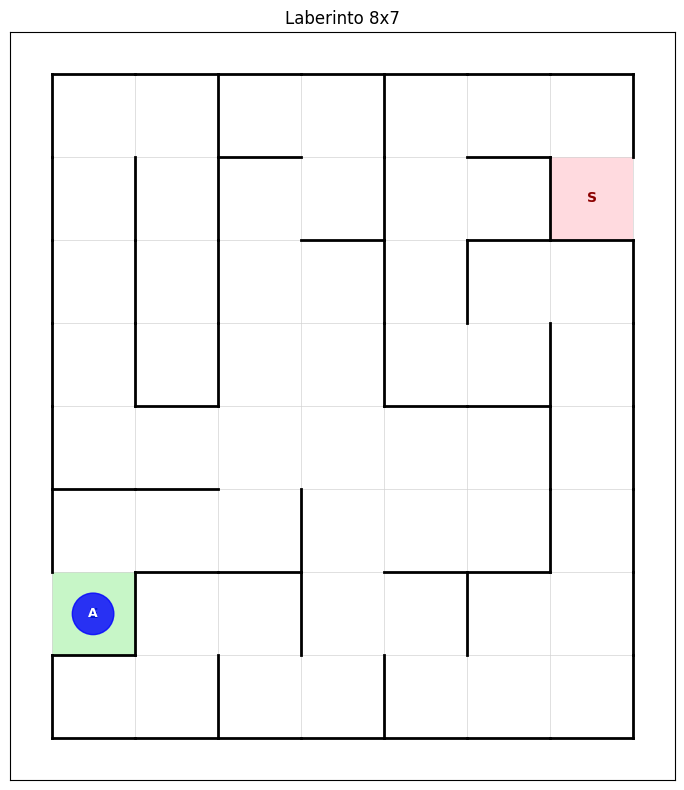

In [5]:
# Crear el entorno con la nueva clase GridWorld
#env = GridWorld('laberintos/project_lab_v2.txt')
env = GridWorld('laberintos/laberinto_8x7.txt')
print('Inicio:', env.start_state, 'Meta:', env.goal_states)

# Visualizar
env.visualize()

In [6]:
# Hiperparámetros
EPISODES = 3000          # Ajusta según convergencia
ALPHA = 0.15             # Tasa de aprendizaje
GAMMA = 0.99             # Factor de descuento
EPSILON_START = 0.9      # Exploración inicial
EPSILON_MIN = 0.01       # Exploración mínima
EPSILON_DECAY = 0.99    # Decaimiento multiplicativo por episodio
MAX_STEPS_EPISODE = 100  # Tope para evitar loops infinitos
MAZE = 'laberintos/project_lab_v2.txt'

# Inicializar entorno y agente
env = GridWorld(MAZE)
agent = QLearningAgent(env, alpha = ALPHA, gamma = GAMMA, epsilon = EPSILON_START)

Entradas detectadas: [(6, 0)]
Salidas detectadas: [(1, 6)]


In [7]:
# Entrenar el agente
episode_rewards, steps_per_episode = agent.run(
    episodes = EPISODES, 
    max_steps_per_episode = MAX_STEPS_EPISODE,
    epsilon_decay = EPSILON_DECAY,
    epsilon_min = EPSILON_MIN
)

Episodio 100 | ε=0.329 | Recompensa media últimas 100: -117.71 | Tiempo transcurrido: 0.22 segundos
Política guardada en qtables/qtable_policy100.json
Episodio 200 | ε=0.121 | Recompensa media últimas 100: 17.48 | Tiempo transcurrido: 0.08 segundos
Política guardada en qtables/qtable_policy200.json
Episodio 300 | ε=0.044 | Recompensa media últimas 100: 74.06 | Tiempo transcurrido: 0.03 segundos
Política guardada en qtables/qtable_policy300.json
Episodio 400 | ε=0.016 | Recompensa media últimas 100: 75.20 | Tiempo transcurrido: 0.03 segundos
Política guardada en qtables/qtable_policy400.json
Episodio 500 | ε=0.010 | Recompensa media últimas 100: 75.62 | Tiempo transcurrido: 0.03 segundos
Política guardada en qtables/qtable_policy500.json
Episodio 600 | ε=0.010 | Recompensa media últimas 100: 75.58 | Tiempo transcurrido: 0.03 segundos
Política guardada en qtables/qtable_policy600.json
Episodio 700 | ε=0.010 | Recompensa media últimas 100: 75.72 | Tiempo transcurrido: 0.04 segundos
Políti

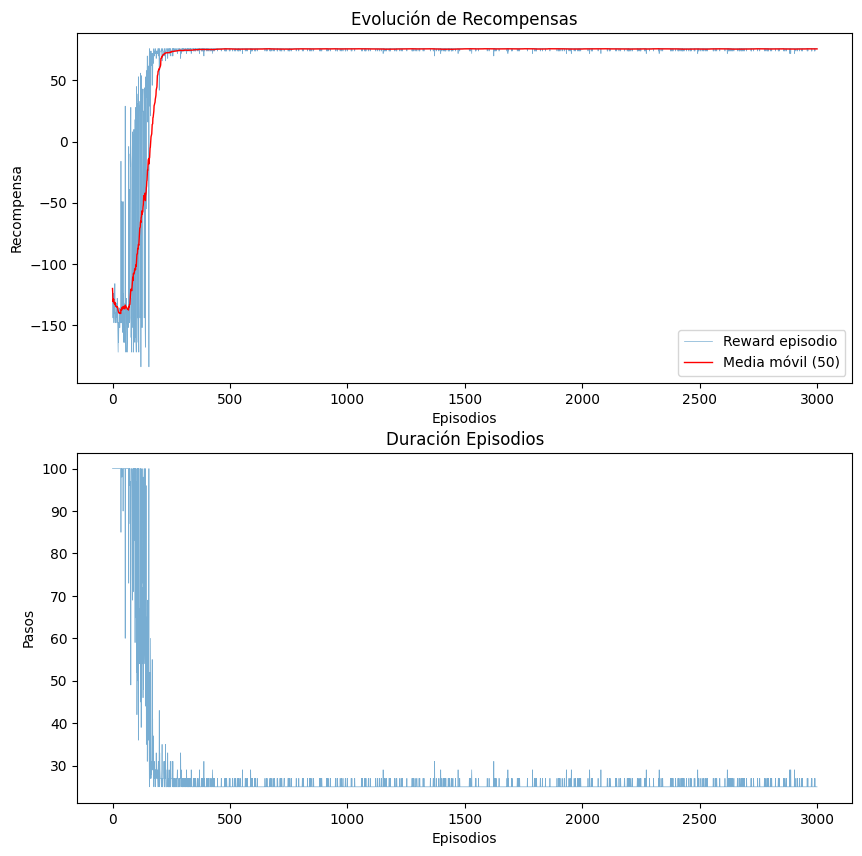

In [8]:
agent.plot_learning_curve(episode_rewards, steps_per_episode)

In [9]:
policy, values = agent.test_performance()

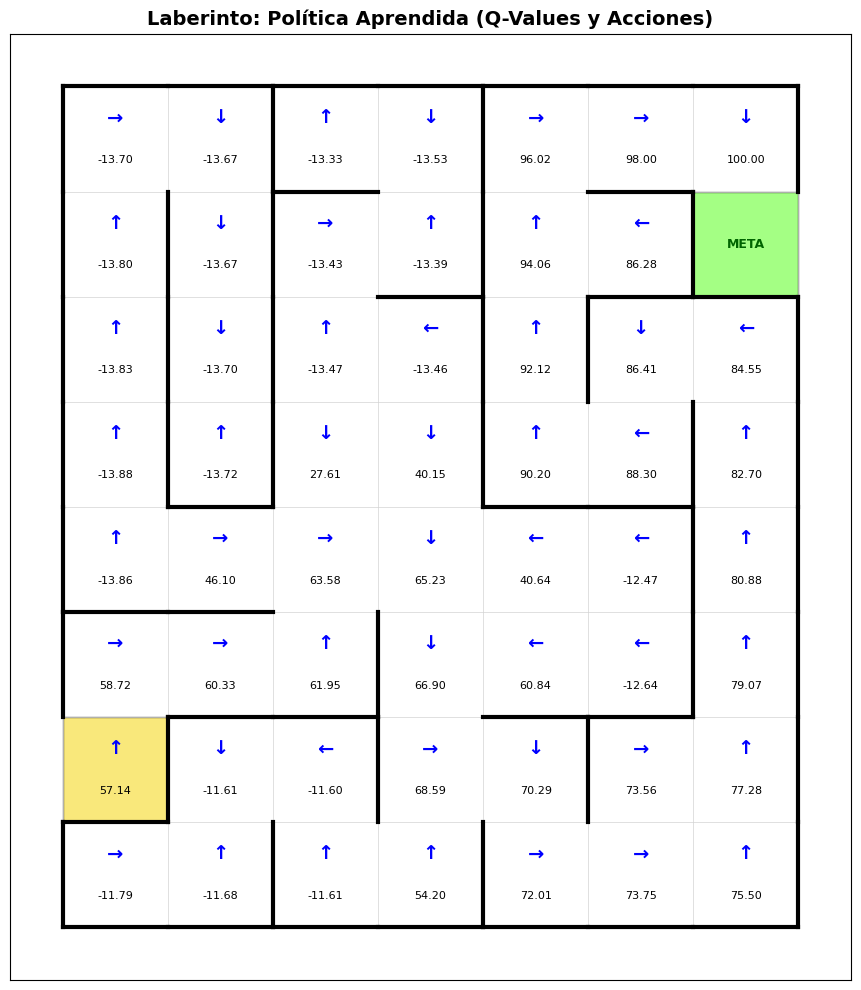

In [10]:
agent.plot_actions(policy, values)

In [11]:
# Crear nuevo agente y cargar política guardada
env_video = GridWorld(MAZE)
agent_video = QLearningAgent(env_video, alpha = 0.1, gamma = 0.9, epsilon = 0.0)  # epsilon = 0 para no explorar
agent_video.load_policy('qtables/qtable_policy3000.json')

# Generar GIF
frames = generate_video_with_qvalues(
    agent_video, 
    output_filename = 'maze_from_qtable.gif', 
    fps = 2,
    max_steps = 100
)

Entradas detectadas: [(6, 0)]
Salidas detectadas: [(1, 6)]
Política cargada desde qtables/qtable_policy3000.json
Trayectoria: 26 estados, 25 acciones
Generando 26 frames...
Guardando GIF en maze_from_qtable.gif...
✓ GIF guardado exitosamente: maze_from_qtable.gif
  Tamaño: 26 frames
  Duración por frame: 500ms


### Visualizar el GIF en el notebook

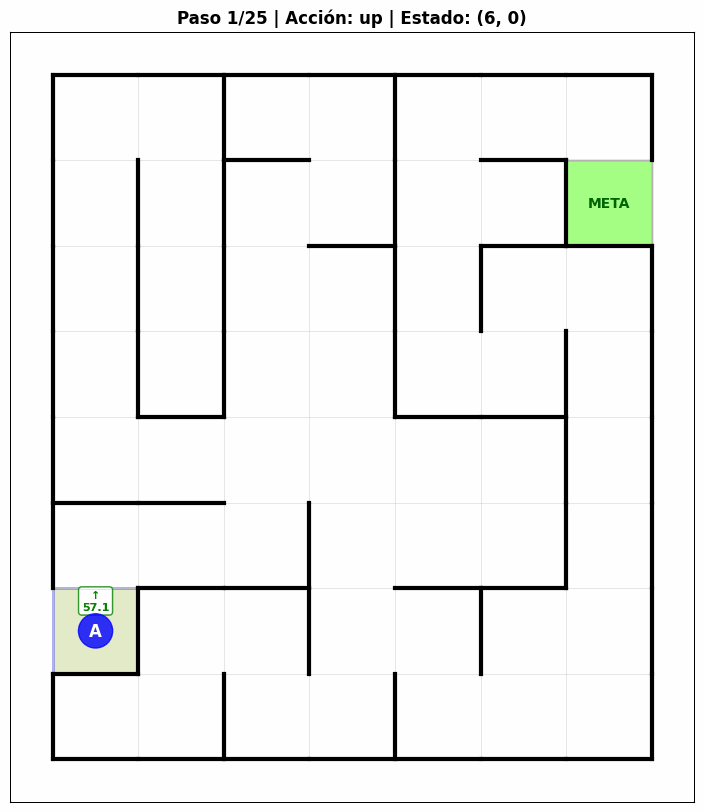

In [12]:
from IPython.display import Image as IPImage, display

# Mostrar GIF en el notebook
display(IPImage(filename = 'maze_from_qtable.gif'))